# Main tasks with Neutral

In [1]:
import numpy as np
import math
import json
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import sys
sns.set_theme(style="white")
os.environ['ROOT_DIR'] = ''
sys.path.append(os.environ['ROOT_DIR'])
from config import *
from collections import Counter

/storage/ukp/work/cai_e/anaconda3/envs/llama2/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Matplotlib created a temporary config/cache directory at /scratch/90992/matplotlib-hfi7pnvf because the default path (/home/cai_e/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def _get_ranks(x, descending=False):
    tmp = x.argsort(descending=descending)
    ranks = torch.zeros_like(tmp)
    ranks[tmp] = torch.arange(len(x))
    return ranks

def spearman_correlation(x_rank, y_rank):
    n = x_rank.size(0)
    upper = 6 * torch.sum((x_rank - y_rank).pow(2))
    down = n * (n ** 2 - 1.0)
    return 1.0 - (upper / down)

def get_pearson(d1, d2):
    key_set = list(set(d1.keys()).intersection(set(d2.keys())))
    res = {}
    for key in key_set:
        res[key] = pearsonr(d1[key], d2[key])
    print([p[0] for p in list(res.values())])
    print(np.mean([p[0] for p in list(res.values())]))
    return res

In [3]:
def remove_sign(digit, round_digits):
    is_neg = digit < 0
    digit = round(digit, round_digits)
    digit_str = str(abs(digit))
    digit_str = digit_str[1:]
    digit_str += '0' * (round_digits - len(digit_str) + 1)
    return ('-' if is_neg else '') + digit_str

In [4]:
name_mapping = {
    'amazon': 'Amazon',
    'yelp': 'Yelp',
    'sst5': 'SST-5',
    'app': 'APP',
    'mnli': 'MultiNLI',
    'snli': 'SNLI',
    'tfns': 'TFNS',
    'sicke': 'SICK-E',
}

In [5]:
f1_acc_dict_seeds = {
    'Amazon': [[88.1, 72.3, 80.5], [87.1, 70.7, 81.4], [87.5, 70.0, 79.7]],
    'APP': [[74.4, 60.2, 72.6], [74.0, 59.9, 74.5], [74.2, 60.2, 73.1]],
    'SST-5': [[83.4, 55.0, 77.5], [82.1, 51.2, 73.5], [83.8, 53.1, 76.5]],
    'TFNS': [[93.0, 86.4, 92.8], [93.1, 86.2, 91.5], [92.9, 85.7, 92.4]],
    'Yelp': [[87.8, 75.3, 86.6], [88.1, 75.1, 86.7], [87.8, 75.7, 86.4]],
    'MultiNLI': [[90.9, 87.2, 92.8], [91.2, 87.3, 92.9], [91.1, 87.0, 92.8]],
    'SNLI': [[92.5, 89.4, 95.3], [92.7, 89.0, 95.2], [92.6, 89.3, 95.4]],
    'SICK-E': [[92.6, 89.8, 93.0], [93.1, 85.6, 92.2], [93.0, 85.1, 91.9]],
}

### Performance

In [6]:
f1_acc_dict = {}
f1_acc_dict["Amazon"] = [87.58, 71.01, 80.55]
f1_acc_dict["APP"] = [74.18, 60.10, 73.39]
f1_acc_dict['MultiNLI'] = [91.0, 87.2, 92.8]
f1_acc_dict['SICK-E'] = [92.9, 86.8, 92.4]
f1_acc_dict['SNLI'] = [92.6, 89.2, 95.3]
f1_acc_dict['SST-5'] = [83.10, 53.13, 75.84]
f1_acc_dict['Yelp'] = [87.93, 75.36, 86.58]
f1_acc_dict['TFNS'] = [92.98, 86.11, 92.21]

## GeoHard

### GeoHard with train

In [8]:
# load the result - Sentiment
sentiment_path = ''
sentiment_corr = []
with open(sentiment_path, 'r') as f:
    for line in f.readlines():
        sentiment_corr.append(json.loads(line))

In [9]:
inter_hard = {}
intra_hard = {}
geohard_seeds = {}

inter_hard_train = {}
intra_hard_train = {}
geohard_seeds_train = {}

In [10]:
for dict_ in sentiment_corr:
    origin_name = list(dict_.keys())[0]
    mapped_name = name_mapping[origin_name]
    if mapped_name not in inter_hard:
        inter_hard[mapped_name] = []
        intra_hard[mapped_name] = []
        geohard_seeds[mapped_name] = []
        
        inter_hard_train[mapped_name] = []
        intra_hard_train[mapped_name] = []
        geohard_seeds_train[mapped_name] = []
        
    inter_test = np.array(dict_[origin_name]['Dist']['test'])
    intra_test = np.array(dict_[origin_name]['Variance']['test'])
    
    inter_hard[mapped_name].append(inter_test)
    intra_hard[mapped_name].append(intra_test)
    geohard_seeds[mapped_name].append(inter_test + intra_test)
    
    inter_train = np.array(dict_[origin_name]['Dist']['train'])
    intra_train = np.array(dict_[origin_name]['Variance']['train'])
    
    inter_hard_train[mapped_name].append(inter_train)
    intra_hard_train[mapped_name].append(intra_train)
    geohard_seeds_train[mapped_name].append(inter_train + intra_train)

In [11]:
# load the result - Sentiment
nli_path = ''
nli_corr = []
with open(nli_path, 'r') as f:
    for line in f.readlines():
        nli_corr.append(json.loads(line))

In [12]:
for dict_ in nli_corr:
    origin_name = list(dict_.keys())[0]
    mapped_name = name_mapping[origin_name]
    
    if mapped_name not in inter_hard:
        inter_hard[mapped_name] = {}
        intra_hard[mapped_name] = {}
        geohard_seeds[mapped_name] = {}
        
        inter_hard_train[mapped_name] = {}
        intra_hard_train[mapped_name] = {}
        geohard_seeds_train[mapped_name] = {}
    
    seed_dict = {}

    if dict_['config']['seed'] not in inter_hard[mapped_name]:
        inter_hard[mapped_name][dict_['config']['seed']] = []
        intra_hard[mapped_name][dict_['config']['seed']] = []
        geohard_seeds[mapped_name][dict_['config']['seed']] = []
        
        inter_hard_train[mapped_name][dict_['config']['seed']] = []
        intra_hard_train[mapped_name][dict_['config']['seed']] = []
        geohard_seeds_train[mapped_name][dict_['config']['seed']] = []
        
    inter_test = np.array(dict_[origin_name]['Dist']['test'])
    intra_test = np.array(dict_[origin_name]['Variance']['test'])
    
    inter_hard[mapped_name][dict_['config']['seed']].append(inter_test)
    intra_hard[mapped_name][dict_['config']['seed']].append(intra_test)
    geohard_seeds[mapped_name][dict_['config']['seed']].append(inter_test + intra_test)
    
    inter_train = np.array(dict_[origin_name]['Dist']['train'])
    intra_train = np.array(dict_[origin_name]['Variance']['train'])
    
    inter_hard_train[mapped_name][dict_['config']['seed']].append(inter_train)
    intra_hard_train[mapped_name][dict_['config']['seed']].append(intra_train)
    geohard_seeds_train[mapped_name][dict_['config']['seed']].append(inter_train + intra_train)

In [13]:
for k in ['MultiNLI', 'SNLI', 'SICK-E']:
    inter_hard[k] = [np.mean(np.array(v), axis=0) for seed, v in inter_hard[k].items()]
    intra_hard[k] = [np.mean(np.array(v), axis=0) for seed, v in intra_hard[k].items()]
    geohard_seeds[k] = [np.mean(np.array(v), axis=0) for seed, v in geohard_seeds[k].items()]
    
    inter_hard_train[k] = [np.mean(np.array(v), axis=0) for seed, v in inter_hard_train[k].items()]
    intra_hard_train[k] = [np.mean(np.array(v), axis=0) for seed, v in intra_hard_train[k].items()]
    geohard_seeds_train[k] = [np.mean(np.array(v), axis=0) for seed, v in geohard_seeds_train[k].items()]

#### GeoHard_train results

In [247]:
geohard_train_mean_var = {}
for task in geohard_seeds_train.keys():
    tmp_res = [pearsonr(f1_acc_dict[task], v)[0] for v in geohard_seeds_train[task]]
    geohard_train_mean_var[task] = (np.mean(tmp_res), np.std(tmp_res))
np.mean([x[0] for x in geohard_train_mean_var.values()])

-0.8853902334418096

In [248]:
inter_hard_train_mean_var = {}
for task in inter_hard_train.keys():
    tmp_res = [pearsonr(f1_acc_dict[task], v)[0] for v in inter_hard_train[task]]
    inter_hard_train_mean_var[task] = (np.mean(tmp_res), np.std(tmp_res))
np.mean([x[0] for x in inter_hard_train_mean_var.values()])

-0.7971837711736107

In [249]:
np.var([x[0] if not np.isnan(x[0]) else 0.0 for x in inter_hard_train_mean_var.values()])

0.10061455857385465

In [143]:
intra_hard_train_mean_var = {}
for task in intra_hard_train.keys():
    tmp_res = [pearsonr(f1_acc_dict[task], v)[0] for v in intra_hard_train[task]]
    intra_hard_train_mean_var[task] = (np.mean(tmp_res), np.std(tmp_res))
np.mean([x[0] for x in intra_hard_train_mean_var.values()])s

-0.736221333655556

In [144]:
intra_hard_train_mean_var

{'Amazon': (-0.5857055937880028, 0.023045758023535378),
 'Yelp': (-0.9947457086698845, 0.0051269399673783455),
 'SST-5': (-0.9891854588408998, 0.01067733634565625),
 'TFNS': (0.1573671118024094, 0.0312464054298359),
 'APP': (-0.9539459294997349, 0.02035727752735906),
 'MultiNLI': (-0.9784363063740672, 0.008392876345386978),
 'SNLI': (-0.880465454549737, 0.015426644800929179),
 'SICK-E': (-0.6646533293245306, 0.010595633866965598)}

In [244]:
np.var([x[0] if not np.isnan(x[0]) else 0.0 for x in intra_hard_train_mean_var.values()])

0.13549767965152457

In [145]:
dataset_order = ['Amazon', 'APP', 'SST-5', 'TFNS', 'Yelp', 'MultiNLI', 'SNLI', 'SICK-E']

In [253]:
res_mean_var = geohard_train_mean_var
output_str = ''
output_str_wo_var = ''
for dataset in dataset_order:
    mean_, std_ = res_mean_var[dataset]
    output_str += (remove_sign(mean_, 3) + '\\tiny{$\pm$' + remove_sign(std_, 2) + '}' + ' & ')
    output_str_wo_var += (remove_sign(mean_, 4) + '&')
output_str += remove_sign(np.mean([x[0] for x in res_mean_var.values()]), 4)
output_str_wo_var += remove_sign(np.mean([x[0] for x in res_mean_var.values()]), 4)

In [254]:
print(output_str_wo_var)

-.9998&-.9958&-.9909&-.8852&-.9977&-.8384&-.8882&-.4871&-.8854


In [255]:
np.var([x[0] if not np.isnan(x[0]) else 0.0 for x in res_mean_var.values()])

0.026229602761482465

#### GeoHard results

In [148]:
geohard_mean_var = {}
for task in geohard_seeds.keys():
    tmp_res = [pearsonr(f1_acc_dict[task], v)[0] for v in geohard_seeds[task]]
    geohard_mean_var[task] = (np.mean(tmp_res), np.std(tmp_res))
np.mean([x[0] for x in geohard_mean_var.values()])

-0.7141616742912256

In [149]:
inter_hard_mean_var = {}
for task in inter_hard.keys():
    tmp_res = [pearsonr(f1_acc_dict[task], v)[0] for v in inter_hard[task]]
    inter_hard_mean_var[task] = (np.mean(tmp_res), np.std(tmp_res))
np.mean([x[0] for x in inter_hard_mean_var.values()])

-0.6955606550676809

In [150]:
intra_hard_mean_var = {}
for task in inter_hard.keys():
    tmp_res = [pearsonr(f1_acc_dict[task], v)[0] for v in intra_hard[task]]
    intra_hard_mean_var[task] = (np.mean(tmp_res), np.std(tmp_res))
np.mean([x[0] for x in intra_hard_mean_var.values()])

-0.5565676718439516

### Thrust

In [167]:
thrust_dir = #
thrust_res_seeds = {}
for k in name_mapping.keys():
    if k in TASK_CATEGORY['sentiment']:
#         thrust_res_seeds[k] = json.load(open(os.path.join(thrust_dir, f'results/{k}_thrust_200.json'), 'r'))
        thrust_res_seeds[k] = json.load(open(os.path.join(thrust_dir, f'results/{k}_thrust_200.json'), 'r'))
    else:
        try:
            thrust_res_seeds[k] = json.load(open(os.path.join(thrust_dir, f'results/{k}_thrust_600_uqa.json'), 'r'))
        except:
            pass

In [171]:
thrust_res_seeds['mnli']

{'2': {'2': {'25': [1.5137906463385449,
    1.5137906463385449,
    1.5137906463385449],
   '50': [1.6677879095593888, 1.6677879095593888, 1.6677879095593888],
   '75': [1.705642718629384, 1.705642718629384, 1.705642718629384],
   'mean': [8.044327396711054, 7.961826061253325, 7.932440515420158]},
  '4': {'25': [1.5156469963573265, 1.5156469963573265, 1.5156469963573265],
   '50': [1.669848171335521, 1.669848171335521, 1.669848171335521],
   '75': [1.7083995757810706, 1.7083995757810706, 1.7083995757810706],
   'mean': [7.23974977731395, 7.214117306930114, 7.200169353259288]},
  '42': {'25': [1.5153663506445765, 1.5153663506445765, 1.5153663506445765],
   '50': [1.669438567436653, 1.669438567436653, 1.669438567436653],
   '75': [1.7075795980618138, 1.7075795980618138, 1.7075795980618138],
   'mean': [7.34744035189979, 7.322505080292312, 7.305825959945498]},
  '102': {'25': [1.5130261988462412, 1.5130261988462412, 1.5130261988462412],
   '50': [1.6663987180259552, 1.6663987180259552, 1.

In [172]:
thrust_res_integral_mean = {
    k: np.mean([v__['mean'] for train_seed, v_ in thrust_res_seeds[k].items() for kmeans_seed, v__ in v_.items()], axis=0) for k, v in thrust_res_seeds.items()
}

In [173]:
thrust_res_integral_25 = {
    k: np.mean([v__['25'] for train_seed, v_ in thrust_res_seeds[k].items() for kmeans_seed, v__ in v_.items()], axis=0) for k, v in thrust_res_seeds.items()
}

In [176]:
thrust_res_integral_25

{'amazon': array([0.45484024, 0.57482823, 0.51250634]),
 'yelp': array([0.45456576, 0.39461427, 0.45456576]),
 'sst5': array([0.82114835, 0.80115509, 0.76434368]),
 'app': array([0.5398914 , 0.44710167, 0.49670255]),
 'mnli': array([1.50275973, 1.50275973, 1.50275973]),
 'snli': array([1.58188856, 1.58188856, 1.88000702]),
 'tfns': array([0.55280787, 0.52316148, 0.75156106]),
 'sicke': array([1.58874891, 1.58874891, 1.58874891])}

In [179]:
get_pearson(f1_acc_dict, {name_mapping[k]: v for k, v in thrust_res_integral_25.items()})

[0.9073870384052869, 0.5147955706508669, -0.9978989088993673, 0.0649693750039911, nan, 0.995204464273947, 0.831076740129516, nan]
nan


/storage/ukp/work/cai_e/anaconda3/envs/bkg/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'APP': (0.9073870384052869, 0.2761475470829167),
 'TFNS': (0.5147955706508669, 0.6557356486231932),
 'Amazon': (-0.9978989088993673, 0.04127562259055707),
 'SST-5': (0.0649693750039911, 0.9586100584148297),
 'MultiNLI': (nan, nan),
 'Yelp': (0.995204464273947, 0.06237167327023738),
 'SNLI': (0.831076740129516, 0.3754499485214465),
 'SICK-E': (nan, nan)}

In [182]:
thrust_res_integral_25 = {
    k: np.mean([v__['25'] for train_seed, v_ in thrust_res_seeds[k].items() for kmeans_seed, v__ in v_.items()], axis=0) for k, v in thrust_res_seeds.items()
}

In [183]:
thrust_res_integral_25

{'amazon': array([0.45484024, 0.57482823, 0.51250634]),
 'yelp': array([0.45456576, 0.39461427, 0.45456576]),
 'sst5': array([0.82114835, 0.80115509, 0.76434368]),
 'app': array([0.5398914 , 0.44710167, 0.49670255]),
 'mnli': array([1.50275973, 1.50275973, 1.50275973]),
 'snli': array([1.58188856, 1.58188856, 1.88000702]),
 'tfns': array([0.55280787, 0.52316148, 0.75156106]),
 'sicke': array([1.58874891, 1.58874891, 1.58874891])}

In [184]:
thrust_25_corr = {}
for k, v in thrust_res_seeds.items():
    thrust_25_corr[k] = []
    for train_seed, v_ in thrust_res_seeds[k].items():
        res_kmeans = np.mean([v__['25'] for v__ in v_.values()], axis=0)
        thrust_25_corr[k].append(pearsonr(f1_acc_dict[name_mapping[k]], res_kmeans)[0])
    thrust_25_corr[k] = (np.mean(thrust_25_corr[k]), np.std(thrust_25_corr[k]))

In [185]:
thrust_25_corr

{'amazon': (-0.9780480900711759, 0.037534817482505776),
 'yelp': (0.9952044642739469, 4.965068306494546e-17),
 'sst5': (0.08334284516471016, 0.113965167814663),
 'app': (0.9011664622529999, 0.0316752562875611),
 'mnli': (nan, nan),
 'snli': (0.8310767401295163, 8.599750569898517e-17),
 'tfns': (0.5156736535780221, 0.023944903601084245),
 'sicke': (nan, nan)}

##### Variance calculation

In [186]:
# flat the results
thrust_collect_25 = {}
for k, v in thrust_res_seeds.items():
    thrust_collect_25[name_mapping[k]] = []
    for seed_train, v_ in v.items():
        tmp_res = []
        for seed, v__ in v_.items():
            tmp_res.append(v__['25'])

        thrust_collect_25[name_mapping[k]].append(np.mean(tmp_res, axis=0))

In [187]:
thrust_mean_var = {}
for k, v in thrust_collect_25.items():
    list_of_res = [pearsonr(f1_acc_dict[k], v_)[0] for v_ in v]
    print(k, list_of_res)
    thrust_mean_var[k] = [np.mean(list_of_res), np.std(list_of_res)]
thrust_mean_var

Amazon [-0.9031281068214984, -0.9988267735333222, -0.9930808488602375, -0.9955009069843792, -0.9997038141564418]
Yelp [0.9952044642739469, 0.9952044642739469, 0.995204464273947, 0.9952044642739469, 0.9952044642739469]
SST-5 [0.16028948843708477, -0.10288019163788689, 0.22124022268794916, 0.11860666576103097, 0.019458040575372842]
APP [0.9501321982894477, 0.8883008805739216, 0.8795158505991736, 0.8632798320230899, 0.924603549779366]
MultiNLI [nan, nan, nan, nan, nan]
SNLI [0.8310767401295162, 0.8310767401295163, 0.8310767401295162, 0.8310767401295162, 0.8310767401295163]
TFNS [0.5155215391708169, 0.4985610505339304, 0.4815572854319644, 0.5346562471174291, 0.5480721456359694]
SICK-E [nan, nan, nan, nan, nan]


{'Amazon': [-0.9780480900711759, 0.037534817482505776],
 'Yelp': [0.9952044642739469, 4.965068306494546e-17],
 'SST-5': [0.08334284516471016, 0.113965167814663],
 'APP': [0.9011664622529999, 0.0316752562875611],
 'MultiNLI': [nan, nan],
 'SNLI': [0.8310767401295163, 8.599750569898517e-17],
 'TFNS': [0.5156736535780221, 0.023944903601084245],
 'SICK-E': [nan, nan]}

In [231]:
res_mean_var = thrust_mean_var
output_str_wo_var = ''
for dataset in dataset_order:
    output_str_wo_var += ((remove_sign(res_mean_var[dataset][0], 4) if not np.isnan(res_mean_var[dataset][0]) else ' - ') + '&')
output_str_wo_var += remove_sign(np.mean([x[0] if not np.isnan(x[0]) else 0.0 for x in res_mean_var.values()]), 4)

In [232]:
print(output_str_wo_var)

-.9780&.9012&.0833&.5157&.9952& - &.8311& - &.2936


In [235]:
np.var([x[0] if not np.isnan(x[0]) else 0.0 for x in res_mean_var.values()])

0.3791603277317291

## Spread

In [190]:
# the first row is 8 and 32
spread_dict = {}
spread_log = ''
with open(spread_log, 'r') as f:
    for line in f.readlines():
        tmp_dict = json.loads(line)
        task_name = list(tmp_dict.keys())[0]
        if task_name not in spread_dict:
            spread_dict[task_name] = []
        
        spread_dict[task_name].append(tmp_dict[task_name])

In [191]:
spread_integral_mean_dict = {name_mapping[k]: np.mean(v, axis=0) for k, v in spread_dict.items()}

In [192]:
spread_integral_8_dict = {name_mapping[k]: v[0] for k, v in spread_dict.items()}

In [197]:
spread_integral_8_dict

{'TFNS': [0.8184893727302551, 0.8061259388923645, 0.8185345530509949],
 'APP': [0.8760879039764404, 0.8636221289634705, 0.8620697855949402],
 'Amazon': [0.8394718766212463, 0.8424297571182251, 0.843565046787262],
 'SST-5': [0.8278943300247192, 0.8238585591316223, 0.83000648021698],
 'Yelp': [0.8217257857322693, 0.81930011510849, 0.8106135725975037],
 'SICK-E': [0.8588513135910034, 0.8544031977653503, 0.8627617359161377],
 'MultiNLI': [0.8368757367134094, 0.8316559195518494, 0.8329493403434753],
 'SNLI': [0.8768715262413025, 0.8697685599327087, 0.8638634085655212]}

In [198]:
spread_corr = get_pearson(f1_acc_dict, spread_integral_8_dict)

[0.4550013901547303, 0.9944266704319511, -0.6349901752089929, 0.8369039562655083, 0.4291549232733266, -0.2148350672074487, -0.3934015139060346, 0.8470637222429891]
0.28991548825575364


In [199]:
output_str_wo_var = ''
for dataset in dataset_order:
    output_str_wo_var += (remove_sign(spread_corr[dataset][0], 4) + '&')
output_str_wo_var += remove_sign(np.mean([x[0] for x in spread_corr.values()]), 4)

In [200]:
output_str_wo_var

'-.6350&.4550&.8369&.9944&-.2148&.4292&-.3934&.8471&.2899'

In [236]:
np.var([x[0] if not np.isnan(x[0]) else 0.0 for x in spread_corr.values()])

0.341216656855602

### Sensitivity Analysis

In [11]:
# read the all the files
checkpoint_dict = {}
checkpoint_dict['mnli'] = ['checkpoint-3', 'checkpoint-2', 'checkpoint-2']
checkpoint_dict['snli'] = ['checkpoint-5', 'checkpoint-2', 'checkpoint-2']
checkpoint_dict['sicke'] = ['checkpoint-8', 'checkpoint-8', 'checkpoint-4']
checkpoint_dict['app'] = ['checkpoint-3', 'checkpoint-3', 'checkpoint-1']
checkpoint_dict['amazon'] = ['checkpoint-2', 'checkpoint-1', 'checkpoint-2']
checkpoint_dict['tfns'] = ['checkpoint-4', 'checkpoint-0', 'checkpoint-0']
checkpoint_dict['yelp'] = ['checkpoint-2', 'checkpoint-2', 'checkpoint-1']
checkpoint_dict['sst5'] = ['checkpoint-9', 'checkpoint-8', 'checkpoint-4']

# generate the dir
OUTPUT_DIR = ''

path_list = os.listdir(OUTPUT_DIR)
file_path_dict = {}
for key in checkpoint_dict.keys():
    file_path_dict[key] = []
    for idx, seed in enumerate([1, 10, 100]):
        prefix = key + '_roberta_large_seed' + str(seed) + '_'
        searched_file = [file for file in path_list if file.startswith(prefix)]
        assert len(searched_file) == 1
        path = os.path.join(searched_file[0], checkpoint_dict[key][idx])
        file_path_dict[key].append("$OUTPUT_DIR" + '/' + path)
        
for k, v in file_path_dict.items():
    print(f'model_file["{k}"]=( {v[0]} {v[1]} {v[2]} )')

model_file["mnli"]=( $OUTPUT_DIR/mnli_roberta_large_seed1_06-29-11:46:20/checkpoint-3 $OUTPUT_DIR/mnli_roberta_large_seed10_06-29-11:46:23/checkpoint-2 $OUTPUT_DIR/mnli_roberta_large_seed100_06-29-11:46:38/checkpoint-2 )
model_file["snli"]=( $OUTPUT_DIR/snli_roberta_large_seed1_06-30-09:49:52/checkpoint-5 $OUTPUT_DIR/snli_roberta_large_seed10_06-30-10:05:05/checkpoint-2 $OUTPUT_DIR/snli_roberta_large_seed100_06-30-10:35:40/checkpoint-2 )
model_file["sicke"]=( $OUTPUT_DIR/sicke_roberta_large_seed1_09-22-06:19:02/checkpoint-8 $OUTPUT_DIR/sicke_roberta_large_seed10_09-24-22:17:06/checkpoint-8 $OUTPUT_DIR/sicke_roberta_large_seed100_09-24-22:17:06/checkpoint-4 )
model_file["app"]=( $OUTPUT_DIR/app_roberta_large_seed1_09-23-23:26:25/checkpoint-3 $OUTPUT_DIR/app_roberta_large_seed10_09-24-02:08:38/checkpoint-3 $OUTPUT_DIR/app_roberta_large_seed100_09-24-04:51:09/checkpoint-1 )
model_file["amazon"]=( $OUTPUT_DIR/amazon_roberta_large_seed1_09-22-10:41:14/checkpoint-2 $OUTPUT_DIR/amazon_roberta

In [12]:
sa_result_path = ''
sa_task_seed_dict = {k: [] for k in name_mapping.keys()}
with open(sa_result_path, 'r') as f:
    for l in f.readlines():
        tmp_dict = json.loads(l)
        sa_task_seed_dict[tmp_dict['args']['task']].append([
            tmp_dict['results']['Positive'] if 'Positive' in tmp_dict['results'] else tmp_dict['results']['Entailment'],
            tmp_dict['results']['Neutral'],
            tmp_dict['results']['Negative'] if 'Negative' in tmp_dict['results'] else tmp_dict['results']['Contradiction'],
        ])

In [13]:
sa_task_corr_seed_dict = {}
sa_mean_var = {}
for k, v in sa_task_seed_dict.items():
    sa_task_corr_seed_dict[k] = [pearsonr(f1_acc_dict[name_mapping[k]], v_)[0] for v_ in v]
    sa_mean_var[name_mapping[k]] = (np.mean(sa_task_corr_seed_dict[k]), np.std(sa_task_corr_seed_dict[k]))

In [16]:
sa_mean_var

{'Amazon': (-0.47302261624701253, 0.09031927516586341),
 'Yelp': (-0.8980238233896349, 0.07918506884852056),
 'SST-5': (0.2243671870417383, 0.192864084450428),
 'APP': (0.9619732502463331, 0.023918409525536182),
 'MultiNLI': (0.7219106968668539, 0.02365568257420138),
 'SNLI': (-0.3930207170165287, 0.0695721502615678),
 'TFNS': (0.904655096270071, 0.0495190610020821),
 'SICK-E': (0.9961669853959155, 0.0018021217302357318)}

### Log results

In [227]:
output_str_wo_var = ''
for dataset in dataset_order:
    output_str_wo_var += (remove_sign(sa_mean_var[dataset][0], 4) + '&')
output_str_wo_var += remove_sign(np.mean([x[0] for x in sa_mean_var.values()]), 4)

In [228]:
name_mapping_reverse = {v:k for k, v in name_mapping.items()}
latex_dict = {}

for dataset in geohard_seeds.keys():
    latex_dict[dataset] = []
    for class_ in range(3):
        output_str = ''
        for corr_idx, corr in enumerate([f1_acc_dict_seeds, sa_task_seed_dict, thrust_res_seeds, spread_integral_8_dict, intra_hard_train, inter_hard_train, geohard_seeds_train]):
            # reformat the output
            if corr_idx == 0:
                output_str += (str(round(np.mean(np.array(corr[dataset])[:,class_]).item(),1)) +  '\\tiny{$\pm$' + str(round(np.std(np.array(corr[dataset])[:,class_]).item(), 2)) + '}') + '&'
            elif corr_idx == 1:
                output_str += (str(round(np.mean(np.array(corr[name_mapping_reverse[dataset]])[:,class_]).item(),4)) +  '\\tiny{$\pm$' + str(round(np.std(np.array(corr[name_mapping_reverse[dataset]])[:,class_]).item(), 4)) + '}') + '&'
            elif corr_idx == 2:
                tmp = [v_['25'] for k, v in thrust_res_seeds[name_mapping_reverse[dataset]].items() for k_, v_ in v.items()]
                tmp_mean = np.mean(tmp, axis=0)
                tmp_std = np.std(tmp, axis=0)
                output_str += (str(round(tmp_mean[class_], 3)) +  '\\tiny{$\pm$' + str(round(tmp_std[class_], 3)) + '}' ) + '&'
            elif corr_idx == 3:
                output_str += (str(round(corr[dataset][class_], 3))) + '&'
            elif corr_idx > 3:
                output_str += (str(round(np.mean(np.array(corr[dataset])[:, class_]), 3)) + '\\tiny{$\pm$' +  str(round(np.std(np.array(corr[dataset])[:, class_]), 3)) ) + '}'
                if corr_idx == 6:
                    output_str += '\\\\'
                else:
                    output_str += '&'
        latex_dict[dataset].append(output_str)

In [229]:
for k, v in latex_dict.items():
    print(k)
    for v_ in v:
        print(v_)

Amazon
87.6\tiny{$\pm$0.41}&0.1708\tiny{$\pm$0.0121}&0.455\tiny{$\pm$0.004}&0.839&2.837\tiny{$\pm$0.003}&-11.152\tiny{$\pm$0.096}&-8.316\tiny{$\pm$0.096}\\
71.0\tiny{$\pm$0.96}&0.2511\tiny{$\pm$0.0222}&0.575\tiny{$\pm$0.008}&0.842&2.968\tiny{$\pm$0.007}&-6.786\tiny{$\pm$0.056}&-3.818\tiny{$\pm$0.061}\\
80.5\tiny{$\pm$0.69}&0.3153\tiny{$\pm$0.0158}&0.513\tiny{$\pm$0.027}&0.844&2.712\tiny{$\pm$0.007}&-9.205\tiny{$\pm$0.071}&-6.493\tiny{$\pm$0.076}\\
Yelp
87.9\tiny{$\pm$0.14}&0.0451\tiny{$\pm$0.0021}&0.455\tiny{$\pm$0.006}&0.822&4.043\tiny{$\pm$0.011}&-9.793\tiny{$\pm$0.012}&-5.75\tiny{$\pm$0.016}\\
75.4\tiny{$\pm$0.25}&0.0832\tiny{$\pm$0.0033}&0.395\tiny{$\pm$0.006}&0.819&4.396\tiny{$\pm$0.003}&-6.328\tiny{$\pm$0.009}&-1.931\tiny{$\pm$0.006}\\
86.6\tiny{$\pm$0.12}&0.0639\tiny{$\pm$0.0036}&0.455\tiny{$\pm$0.006}&0.811&4.108\tiny{$\pm$0.015}&-9.19\tiny{$\pm$0.018}&-5.082\tiny{$\pm$0.033}\\
SST-5
83.1\tiny{$\pm$0.73}&0.2242\tiny{$\pm$0.0389}&0.821\tiny{$\pm$0.014}&0.828&1.648\tiny{$\pm$0.02

In [218]:
geohard_seeds

{'Amazon': [array([-6.75512671, -2.66855335, -5.36452961]),
  array([-6.76105165, -2.65705156, -5.38656187]),
  array([-6.55289531, -2.57738352, -5.24249005])],
 'Yelp': [array([-5.23710012, -1.48378849, -4.59600067]),
  array([-5.22519302, -1.46610165, -4.55122566]),
  array([-5.25849199, -1.4703517 , -4.51931047])],
 'SST-5': [array([-4.13541603, -0.98712564, -3.61356807]),
  array([-3.29067445, -0.46148705, -2.82005572]),
  array([-4.01460099, -0.92941236, -3.37056112])],
 'TFNS': [array([-3.22272873, -0.40730572, -2.84613585]),
  array([-3.19509578, -0.87550807, -3.12154078]),
  array([-3.07979178, -0.81808972, -2.96648979])],
 'APP': [array([-1.64972782,  1.57006645, -1.72521973]),
  array([-2.51285505,  1.06450415, -2.234478  ]),
  array([-0.66572905,  2.12109852, -0.48402882])],
 'MultiNLI': [array([4.00341498, 4.02670706, 3.97707979]),
  array([3.96895744, 3.98831667, 3.94443313]),
  array([3.98046498, 3.98893672, 3.95278854])],
 'SNLI': [array([5.25300114, 5.14876559, 5.213359

# Other tasks

In [7]:
f1_acc_dict = {}
f1_acc_dict['emo'] = [0.824, 0.8979, 0.9009, 0.9146]
f1_acc_dict['agnews'] = [0.964, 0.9916, 0.9271, 0.9317]
f1_acc_dict['carar'] = [0.909, 0.8912, 0.9047, 0.9317, 0.9013, 0.9508]
f1_acc_dict['yahoo'] = [0.6484, 0.7772, 0.8202, 0.5971, 0.8781, 0.919, 0.596, 0.7677, 0.7875, 0.8152]

In [8]:
def get_task_stats(task, result_lines):
    """
    task: str, the name of task
    results: list of dict
    """
    returned = {}
    returned['Variance'] = []
    returned['Dist'] = []
    returned['GeoHard'] = []
    filtered_lines = [line for line in result_lines if task in line.keys()]
    for line in filtered_lines:
        returned['Variance'].append(line[task]['Variance']['train'])
        returned['Dist'].append(line[task]['Dist']['train'])
        returned['GeoHard'].append(line[task]['GeoHard'])
    return returned

In [9]:
def calculate_mean_var(list_of_dict):
    results = {}
    for dict_ in list_of_dict:
        for k, v in dict_.items():
            if k not in results:
                results[k] = []
            results[k].append(v[0])
    print(results)
    for k, v in results.items():
        results[k] = [np.mean(v), np.std(v)]
    return results

In [10]:
log_path = ''
with open(log_path, 'r') as f:
    results = [json.loads(line) for line in f.readlines()]

In [11]:
other_intra = {}
other_intra['agnews'] = get_task_stats('agnews', results)['Variance']
other_intra['yahoo'] = get_task_stats('yahoo', results)['Variance']
other_intra['emo'] = get_task_stats('emo', results)['Variance']
other_intra['carar'] = get_task_stats('carar', results)['Variance']

In [33]:
for key in other_intra.keys():
    print(key)
    mean_list = [str(x)[:5] for x in np.mean(other_intra[key], axis=0)]
    var_list = [remove_sign(x, 3) for x in np.std(other_intra[key], axis=0)]
    output_str = ''
    for mean_, var_ in zip(mean_list, var_list):
        output_str += (mean_ + '\\tiny{$\pm$' + var_ + '}' + '&')
    output_str = output_str[:-1] + '\\\\'
    print(output_str)

agnews
4.464\tiny{$\pm$.016}&3.835\tiny{$\pm$.034}&3.775\tiny{$\pm$.042}&3.978\tiny{$\pm$.070}\\
yahoo
3.088\tiny{$\pm$.014}&2.920\tiny{$\pm$.009}&2.726\tiny{$\pm$.013}&3.416\tiny{$\pm$.014}&2.550\tiny{$\pm$.021}&3.156\tiny{$\pm$.004}&4.257\tiny{$\pm$.042}&4.481\tiny{$\pm$.066}&3.195\tiny{$\pm$.020}&2.814\tiny{$\pm$.027}\\
emo
2.331\tiny{$\pm$.025}&2.286\tiny{$\pm$.024}&2.120\tiny{$\pm$.015}&2.117\tiny{$\pm$.006}\\
carar
1.817\tiny{$\pm$.129}&2.285\tiny{$\pm$.068}&1.656\tiny{$\pm$.013}&1.641\tiny{$\pm$.075}&1.505\tiny{$\pm$.040}&1.675\tiny{$\pm$.007}\\


In [13]:
other_inter = {}
other_inter['agnews'] = get_task_stats('agnews', results)['Dist']
other_inter['yahoo'] = get_task_stats('yahoo', results)['Dist']
other_inter['emo'] = get_task_stats('emo', results)['Dist']
other_inter['carar'] = get_task_stats('carar', results)['Dist']

In [36]:
for key in other_inter.keys():
    print(key)
    mean_list = [str(x)[:6] for x in np.mean(other_inter[key], axis=0)]
    var_list = [remove_sign(x, 3) for x in np.std(other_inter[key], axis=0)]
    output_str = ''
    for mean_, var_ in zip(mean_list, var_list):
        output_str += (mean_ + '\\tiny{$\pm$' + var_ + '}' + '&')
    output_str = output_str[:-1] + '\\\\'
    print(output_str)

agnews
-15.49\tiny{$\pm$.133}&-17.62\tiny{$\pm$.100}&-13.11\tiny{$\pm$.221}&-13.35\tiny{$\pm$.075}\\
yahoo
-7.836\tiny{$\pm$.033}&-8.894\tiny{$\pm$.012}&-11.63\tiny{$\pm$.092}&-6.872\tiny{$\pm$.006}&-12.38\tiny{$\pm$.137}&-13.97\tiny{$\pm$.053}&-7.303\tiny{$\pm$.053}&-8.428\tiny{$\pm$.042}&-10.11\tiny{$\pm$.062}&-7.294\tiny{$\pm$.066}\\
emo
-6.841\tiny{$\pm$.081}&-9.781\tiny{$\pm$.147}&-9.521\tiny{$\pm$.186}&-8.278\tiny{$\pm$.428}\\
carar
-6.538\tiny{$\pm$.144}&-6.232\tiny{$\pm$.216}&-5.806\tiny{$\pm$.079}&-7.159\tiny{$\pm$.122}&-6.043\tiny{$\pm$.123}&-6.822\tiny{$\pm$.116}\\


In [14]:
other_geohard = {}
other_geohard['agnews'] = get_task_stats('agnews', results)['GeoHard']
other_geohard['yahoo'] = get_task_stats('yahoo', results)['GeoHard']
other_geohard['emo'] = get_task_stats('emo', results)['GeoHard']
other_geohard['carar'] = get_task_stats('carar', results)['GeoHard']

In [37]:
for key in other_geohard.keys():
    print(key)
    mean_list = [str(x)[:6] for x in np.mean(other_geohard[key], axis=0)]
    var_list = [remove_sign(x, 3) for x in np.std(other_geohard[key], axis=0)]
    output_str = ''
    for mean_, var_ in zip(mean_list, var_list):
        output_str += (mean_ + '\\tiny{$\pm$' + var_ + '}' + '&')
    output_str = output_str[:-1] + '\\\\'
    print(output_str)

agnews
-11.02\tiny{$\pm$.119}&-13.79\tiny{$\pm$.084}&-9.340\tiny{$\pm$.253}&-9.377\tiny{$\pm$.018}\\
yahoo
-4.747\tiny{$\pm$.019}&-5.974\tiny{$\pm$.003}&-8.910\tiny{$\pm$.080}&-3.455\tiny{$\pm$.015}&-9.838\tiny{$\pm$.117}&-10.81\tiny{$\pm$.056}&-3.045\tiny{$\pm$.012}&-3.946\tiny{$\pm$.025}&-6.922\tiny{$\pm$.043}&-4.480\tiny{$\pm$.042}\\
emo
-4.509\tiny{$\pm$.063}&-7.495\tiny{$\pm$.170}&-7.400\tiny{$\pm$.177}&-6.160\tiny{$\pm$.425}\\
carar
-4.720\tiny{$\pm$.263}&-3.947\tiny{$\pm$.199}&-4.150\tiny{$\pm$.066}&-5.517\tiny{$\pm$.196}&-4.537\tiny{$\pm$.107}&-5.147\tiny{$\pm$.111}\\


In [62]:
get_pearson(f1_acc_dict, {k: np.mean(v, axis=0) for k, v in other_geohard.items()})

[-0.8414818411050834, -0.8084413045331822, -0.9812895992022488, -0.8378657807313479]
-0.8672696313929655


{'carar': PearsonRResult(statistic=-0.8414818411050834, pvalue=0.03570038736980438),
 'emo': PearsonRResult(statistic=-0.8084413045331822, pvalue=0.1915586954668178),
 'agnews': PearsonRResult(statistic=-0.9812895992022488, pvalue=0.018710400797751214),
 'yahoo': PearsonRResult(statistic=-0.8378657807313479, pvalue=0.0024738753050885256)}

In [40]:
other_geohard_list = []
for idx in range(3):
    other_geohard_list.append(get_pearson(f1_acc_dict, {k: v[idx] for k, v in other_geohard.items()}))

[-0.9827545425708288, -0.9019217389395346, -0.8912358222426132, -0.8439531893166774]
-0.9049663232674136
[-0.9750813249949211, -0.7701528107258373, -0.6566643397135639, -0.8352480827382252]
-0.8092866395431368
[-0.9823941401504335, -0.7205644958171393, -0.903580974057367, -0.8341213669654053]
-0.8601652442475862


In [42]:
other_geohard_corr = calculate_mean_var(other_geohard_list)
other_geohard_corr

{'agnews': [-0.9827545425708288, -0.9750813249949211, -0.9823941401504335], 'emo': [-0.9019217389395346, -0.7701528107258373, -0.7205644958171393], 'carar': [-0.8912358222426132, -0.6566643397135639, -0.903580974057367], 'yahoo': [-0.8439531893166774, -0.8352480827382252, -0.8341213669654053]}


{'agnews': [-0.9800766692387278, 0.003535304848878568],
 'emo': [-0.7975463484941704, 0.076530677255759],
 'carar': [-0.8171603786711814, 0.11359969068075887],
 'yahoo': [-0.8377742130067692, 0.004393342181603477]}

In [64]:
other_intra_list = []
for idx in range(3):
    other_intra_list.append(get_pearson(f1_acc_dict, {k: v[idx] for k, v in other_intra.items()}))

[0.06517845010250711, -0.8618064218273234, -0.4072653277468417, -0.5189315247358142]
-0.43070620605186805
[0.2624222089904493, -0.8083868472670417, -0.4429472468027426, -0.5058086420331822]
-0.3736801317781293
[0.19403954745675436, -0.606589447555856, -0.4421824374054053, -0.49354300625908043]
-0.33706883594089687


In [65]:
other_intra_corr = calculate_mean_var(other_intra_list)
other_intra_corr

{'agnews': [0.06517845010250711, 0.2624222089904493, 0.19403954745675436], 'emo': [-0.8618064218273234, -0.8083868472670417, -0.606589447555856], 'carar': [-0.4072653277468417, -0.4429472468027426, -0.4421824374054053], 'yahoo': [-0.5189315247358142, -0.5058086420331822, -0.49354300625908043]}


{'agnews': [0.1738800688499036, 0.08177643726785944],
 'emo': [-0.7589275722167402, 0.10990477971239994],
 'carar': [-0.4307983373183299, 0.01664327968425252],
 'yahoo': [-0.5060943910093589, 0.010366788540620222]}

In [46]:
other_inter_list = []
for idx in range(3):
    other_inter_list.append(get_pearson(f1_acc_dict, {k: v[idx] for k, v in other_inter.items()}))

[-0.9982584973574451, -0.8743224379524377, -0.7740471037623663, -0.8286185809950924]
-0.8688116550168354
[-0.996057219217301, -0.7302642780119135, -0.5345456067244033, -0.8184204910926295]
-0.7698218987615618
[-0.999498172661514, -0.68556215507837, -0.8694326732114988, -0.8170602656032766]
-0.8428883166386649


In [68]:
other_inter_corr = calculate_mean_var(other_inter_list)
other_inter_corr

{'agnews': [-0.9982584973574451, -0.996057219217301, -0.999498172661514], 'emo': [-0.8743224379524377, -0.7302642780119135, -0.68556215507837], 'carar': [-0.7740471037623663, -0.5345456067244033, -0.8694326732114988], 'yahoo': [-0.8286185809950924, -0.8184204910926295, -0.8170602656032766]}


{'agnews': [-0.9979379630787534, 0.0014229305017399133],
 'emo': [-0.7633829570142404, 0.08054086445947334],
 'carar': [-0.7260084612327562, 0.14087375011489028],
 'yahoo': [-0.8213664458969996, 0.005158013245182353]}

In [81]:
task_order = ['agnews', 'yahoo', 'emo', 'carar']
output_str = ''
for task in task_order:
    output_str += ( str(remove_sign(other_intra_corr[task][0], 3)) + '\\tiny{$\pm$' + str(remove_sign(other_intra_corr[task][1], 1)) + '}' + '&' )
print(output_str)

.174\tiny{$\pm$.1}&-.506\tiny{$\pm$.0}&-.759\tiny{$\pm$.1}&-.431\tiny{$\pm$.0}&


In [82]:
task_order = ['agnews', 'yahoo', 'emo', 'carar']
output_str = ''
for task in task_order:
    output_str += ( str(remove_sign(other_inter_corr[task][0], 3)) + '\\tiny{$\pm$' + str(remove_sign(other_inter_corr[task][1], 1)) + '}' + '&' )
print(output_str)

-.998\tiny{$\pm$.0}&-.821\tiny{$\pm$.0}&-.763\tiny{$\pm$.1}&-.726\tiny{$\pm$.1}&


In [83]:
task_order = ['agnews', 'yahoo', 'emo', 'carar']
output_str = ''
for task in task_order:
    output_str += ( str(remove_sign(other_geohard_corr[task][0], 3)) + '\\tiny{$\pm$' + str(remove_sign(other_geohard_corr[task][1], 1)) + '}' + '&' )
print(output_str)

-.980\tiny{$\pm$.0}&-.838\tiny{$\pm$.0}&-.798\tiny{$\pm$.1}&-.817\tiny{$\pm$.1}&


## R1.2 with other embedding models

In [23]:
# load the result - Sentiment
sentiment_other_embeds_path = ''
sentiment_other_embeds_corr = []
with open(sentiment_other_embeds_path, 'r') as f:
    for line in f.readlines():
        sentiment_other_embeds_corr.append(json.loads(line))

In [27]:
sentiment_other_embeds_corr

[{'amazon': {'Variance': {'train': [2.627307176589966,
     2.897934913635254,
     2.8875205516815186],
    'test': [3.2067315578460693, 3.3349738121032715, 3.0640997886657715]},
   'Dist': {'train': [-7.840254306793213,
     -4.742176055908203,
     -6.38627290725708],
    'test': [-6.679200172424316, -4.018896102905273, -5.37748908996582]},
   'GeoHard': [-5.212947130203247, -1.8442411422729492, -3.4987523555755615]},
  'config': {'task': 'amazon',
   'max_seq_length': 128,
   'learning_rate': 1e-06,
   'train_batch_size': -1,
   'predict_batch_size': 128,
   'save_path': '/storage/ukp/work/cai_e/knowledge_measurement/class_hardness/outputs/e5_large/amazon',
   'seed': 100,
   'model_name_or_path': 'princeton-nlp/sup-simcse-bert-base-uncased',
   'train_embeddings_path': '',
   'test_embeddings_path': '',
   'train_dataloader_path': '',
   'encode': False,
   'biased_class': -1,
   'balanced': True,
   'encoder_type': 'gte',
   'target_weight': 0.0,
   'passage': False,
   'transfor

In [54]:
inter_hard = {}
intra_hard = {}
geohard_seeds = {}

inter_hard_train = {}
intra_hard_train = {}
geohard_seeds_train = {}

In [55]:
for dict_ in sentiment_other_embeds_corr:
    if dict_['config']['encoder_type'] != 'bge':
        continue
    origin_name = list(dict_.keys())[0]
    mapped_name = name_mapping[origin_name]
    
    if mapped_name not in inter_hard:
        inter_hard[mapped_name] = {}
        intra_hard[mapped_name] = {}
        geohard_seeds[mapped_name] = {}
        
        inter_hard_train[mapped_name] = {}
        intra_hard_train[mapped_name] = {}
        geohard_seeds_train[mapped_name] = {}
    
    seed_dict = {}

    if dict_['config']['seed'] not in inter_hard[mapped_name]:
        inter_hard[mapped_name][dict_['config']['seed']] = []
        intra_hard[mapped_name][dict_['config']['seed']] = []
        geohard_seeds[mapped_name][dict_['config']['seed']] = []
        
        inter_hard_train[mapped_name][dict_['config']['seed']] = []
        intra_hard_train[mapped_name][dict_['config']['seed']] = []
        geohard_seeds_train[mapped_name][dict_['config']['seed']] = []
        
    inter_test = np.array(dict_[origin_name]['Dist']['test'])
    intra_test = np.array(dict_[origin_name]['Variance']['test'])
    
    inter_hard[mapped_name][dict_['config']['seed']].append(inter_test)
    intra_hard[mapped_name][dict_['config']['seed']].append(intra_test)
    geohard_seeds[mapped_name][dict_['config']['seed']].append(inter_test + intra_test)
    
    inter_train = np.array(dict_[origin_name]['Dist']['train'])
    intra_train = np.array(dict_[origin_name]['Variance']['train'])
    
    inter_hard_train[mapped_name][dict_['config']['seed']].append(inter_train)
    intra_hard_train[mapped_name][dict_['config']['seed']].append(intra_train)
    geohard_seeds_train[mapped_name][dict_['config']['seed']].append(inter_train + intra_train)

In [56]:
geohard_seeds_train

{'Amazon': {100: [array([-5.58666325, -2.58603048, -4.79934931])],
  200: [array([-5.75170588, -2.67132807, -4.89994597])],
  300: [array([-5.62938976, -2.61009789, -4.86158729])]},
 'Yelp': {100: [array([ 1.48023605,  1.05268764, -1.11725831])],
  200: [array([ 1.11878872,  0.84081864, -1.17315936])],
  300: [array([ 1.29385757,  0.99701095, -1.09138846])]},
 'SST-5': {100: [array([-5.60412335, -3.10561395, -5.23862362])],
  200: [array([-5.98154306, -3.23281777, -5.61492312])],
  300: [array([-7.05100882, -3.81130373, -6.43963325])]},
 'TFNS': {100: [array([-4.55606747, -2.82439303, -5.02712893])],
  200: [array([-4.80053127, -2.79959416, -4.63697886])],
  300: [array([-4.67236137, -2.75080991, -4.99855137])]},
 'APP': {100: [array([-0.23348618,  1.58320045, -0.7644453 ])],
  200: [array([-0.80455542,  1.17020464, -1.30273485])],
  300: [array([-1.21355391,  1.27983046, -1.06220913])]}}

In [48]:
sentiment_datasets = ['Amazon', 'APP', 'SST-5', 'Yelp', 'TFNS']
gte_geohard_seeds_train = {k: np.mean(np.array([l for l in v.values()]), axis=0)[0] for k, v in geohard_seeds_train.items() if k in sentiment_datasets}

In [49]:
get_pearson(f1_acc_dict, gte_geohard_seeds_train)

[-0.9971666726343802, -0.9992883103431781, -0.9996974246460084, -0.9962068006204683, -0.2577404009093196]
-0.8500199218306708


{'SST-5': (-0.9971666726343802, 0.04793426734766629),
 'TFNS': (-0.9992883103431781, 0.024019624188905336),
 'APP': (-0.9996974246460084, 0.01566112107244687),
 'Amazon': (-0.9962068006204683, 0.05546708366607745),
 'Yelp': (-0.2577404009093196, 0.8340441370422337)}

In [52]:
simcse_geohard_seeds_train = {k: np.mean(np.array([l for l in v.values()]), axis=0)[0] for k, v in geohard_seeds_train.items() if k in sentiment_datasets}

In [53]:
get_pearson(f1_acc_dict, simcse_geohard_seeds_train)

[-0.9898410113721232, 0.31321733327199475, -0.8911658033414319, -0.9974718890609231, -0.9594884587112191]
-0.7049499658427405


{'SST-5': (-0.9898410113721232, 0.09082150841632643),
 'TFNS': (0.31321733327199475, 0.7971863408283251),
 'APP': (-0.8911658033414319, 0.29977656978546946),
 'Amazon': (-0.9974718890609231, 0.04527773804596771),
 'Yelp': (-0.9594884587112191, 0.181828383685861)}

In [57]:
bge_geohard_seeds_train = {k: np.mean(np.array([l for l in v.values()]), axis=0)[0] for k, v in geohard_seeds_train.items() if k in sentiment_datasets}

In [58]:
get_pearson(f1_acc_dict, bge_geohard_seeds_train)

[-0.996259165952751, -0.9812176153984457, -0.9868202718992181, -0.9841474056730489, -0.29376491018398965]
-0.8484418738214907


{'SST-5': (-0.996259165952751, 0.055082649286797195),
 'TFNS': (-0.9812176153984457, 0.12358125334927587),
 'APP': (-0.9868202718992181, 0.10347286953614879),
 'Amazon': (-0.9841474056730489, 0.113506489747713),
 'Yelp': (-0.29376491018398965, 0.8101834360518109)}

### Plot the bar

In [19]:
sa_sc = [-0.473, 0.962, 0.2244, 0.9047, -0.8980]
thrust_sc = [-0.978, 0.912, 0.0833, 0.5157, 0.9952]
spread_sc = [-0.6350, 0.4550, 0.8369, 0.9944, -0.2148]

gte_sc = [0.9962, 0.9997, 0.9972, 0.2577, 0.9993, 0.8500]
bge_sc = [0.9841, 0.9868, 0.9963, 0.2938, 0.9812, 0.8484]
e5large_sc = [0.9998, 0.9958, 0.9909, 0.9977, 0.8852, 0.9513]

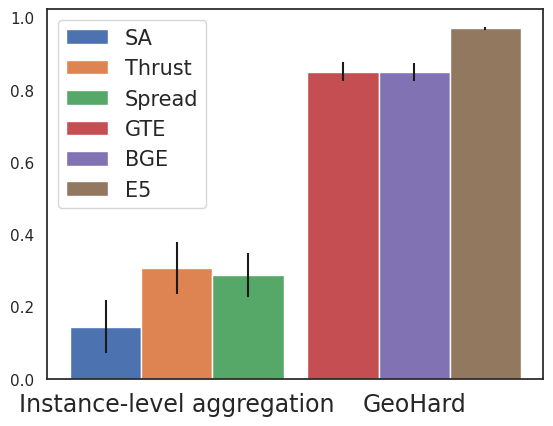

In [40]:
ins_measure = [sa_sc, thrust_sc, spread_sc]
class_measure = [gte_sc, bge_sc, e5large_sc]

ins_measure_mean = [np.mean(v) for v in ins_measure]
ins_measure_std = [np.std(v) for v in ins_measure]

class_measure_mean = [np.mean(v) for v in class_measure]
class_measure_std = [np.std(v) for v in class_measure]

ind = np.arange(2)

width = 0.3
fig, ax = plt.subplots()

plt.bar(-width, ins_measure_mean[0], width, yerr=ins_measure_std[0]/10, label='SA')
plt.bar(0, ins_measure_mean[1], width, yerr=ins_measure_std[1]/10, label='Thrust')
plt.bar(width, ins_measure_mean[2], width, yerr=ins_measure_std[2]/10, label='Spread')

plt.bar(1-width, class_measure_mean[0], width, yerr=class_measure_std[0]/10, label='GTE')
plt.bar(1, class_measure_mean[1], width, yerr=class_measure_std[1]/10, label='BGE')
plt.bar(1+width, class_measure_mean[2], width, yerr=class_measure_std[2]/10, label='E5')

plt.legend(loc='best', fontsize=15)

ax.set_xticks([0, 1])
ax.set_xticklabels(['Instance-level aggregation', 'GeoHard'], fontsize=17)

plt.savefig('./instance_vs_geohard.pdf', bbox_inches='tight')